Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
import torch.nn as nn
MNIST_dataset=MNIST(root='data/',download=True,transform=ToTensor())

Split Dataset to Train and Test Dataset

In [24]:
def split_indices(n, val_pct):
  n_val=int(val_pct*n)
  idxs=np.random.permutation(n)
  return idxs[n_val:],idxs[:n_val]

In [25]:
batch_size=100
train_indices,val_indices=split_indices(len(MNIST_dataset),val_pct=0.2)
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(MNIST_dataset,batch_size,sampler=train_sampler)
valid_sampler=SubsetRandomSampler(val_indices)
valid_dl=DataLoader(MNIST_dataset,batch_size,sampler=valid_sampler)

Use GPU

In [26]:
device= torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [27]:
def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return[to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

In [28]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

In [29]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

Feedforward Neural Network Model

In [30]:
class MnistModel(nn.Module):
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    self.linear1=nn.Linear(in_size,hidden_size)
    self.linear2=nn.Linear(hidden_size,out_size)
  def forward(self,xb):
    xb=xb.view(xb.size(0),-1)
    out=self.linear1(xb)
    out=F.relu(out)
    return(out)

In [31]:
input_size=784
num_classes=10
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)

In [33]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [34]:
for images,labels in train_dl:
  outputs=model(images)
  loss=F.cross_entropy(outputs,labels)
  print('Loss:',loss.item())
  break
print('outputs.shape:',outputs.shape)
print('Sample Outputs:\n',outputs[:2].data)

Loss: 3.4242818355560303
outputs.shape: torch.Size([100, 32])
Sample Outputs:
 tensor([[0.0000, 0.0445, 0.1109, 0.3665, 0.0000, 0.0000, 0.0234, 0.0409, 0.1860,
         0.0000, 0.0000, 0.0661, 0.1120, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0195, 0.0000, 0.0000, 0.0000, 0.1733, 0.0000, 0.0788, 0.1299,
         0.3914, 0.0543, 0.0000, 0.0000, 0.3003],
        [0.0000, 0.1373, 0.0000, 0.0900, 0.0000, 0.0000, 0.0314, 0.2902, 0.2715,
         0.0000, 0.0000, 0.2331, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0676, 0.0159, 0.0000, 0.0000, 0.1374,
         0.3083, 0.0010, 0.1085, 0.2078, 0.0000]])


Train the Model

In [35]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
  preds=model(xb)
  loss=loss_func(preds,yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()

  metric_result=None
  if metric is not None:
    metric_result=metric(preds,yb)

  return loss.item(), len(xb),metric_result


In [36]:
def evaluate(model, loss_fn,valid_dl,metric=None):
  with torch.no_grad():
    results=[loss_batch(model, loss_fn, xb,yb,metric=metric)for xb,yb in valid_dl]
    losses, nums, metrics= zip(*results)
    total= np.sum(nums)
    avg_loss= np.sum(np.multiply(losses,nums))/total
    avg_metric=None
    if metric is not None:
      avg_metric= np.sum(np.multiply(metrics,nums))/total
  return avg_loss, total, avg_metric

In [37]:
def fit(epochs, lr, model, loss_fn, train_dl, valid_dl , metric=None, opt_fn=None):
  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(epochs):
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result
    if metric is None:
      print('Epoch[{}/{}],Loss:{:.4f}'.format(epoch+1, epochs, val_loss))
    else:
      print('Epoch[{}/{}],Loss:{:.4f},{}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))


In [38]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.sum(preds==labels).item()/len(preds)

In [39]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)
model =to_device(model,device)

In [40]:
evaluate(model,F.cross_entropy,valid_dl,accuracy)

(np.float64(3.4687880913416547), np.int64(12000), np.float64(0.0225))

In [41]:
fit(5,0.5,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/5],Loss:0.3289,accuracy: 0.9063
Epoch[2/5],Loss:0.3008,accuracy: 0.9179
Epoch[3/5],Loss:0.2973,accuracy: 0.9169
Epoch[4/5],Loss:0.3058,accuracy: 0.9125
Epoch[5/5],Loss:0.2975,accuracy: 0.9139


In [42]:
fit(5,0.5,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/5],Loss:0.2833,accuracy: 0.9216
Epoch[2/5],Loss:0.2866,accuracy: 0.9198
Epoch[3/5],Loss:0.2833,accuracy: 0.9235
Epoch[4/5],Loss:0.2925,accuracy: 0.9173
Epoch[5/5],Loss:0.2851,accuracy: 0.9219


In [43]:
fit(5,0.05,model,F.cross_entropy,train_dl,valid_dl,accuracy)

Epoch[1/5],Loss:0.2777,accuracy: 0.9231
Epoch[2/5],Loss:0.2772,accuracy: 0.9250
Epoch[3/5],Loss:0.2772,accuracy: 0.9252
Epoch[4/5],Loss:0.2770,accuracy: 0.9250
Epoch[5/5],Loss:0.2771,accuracy: 0.9250


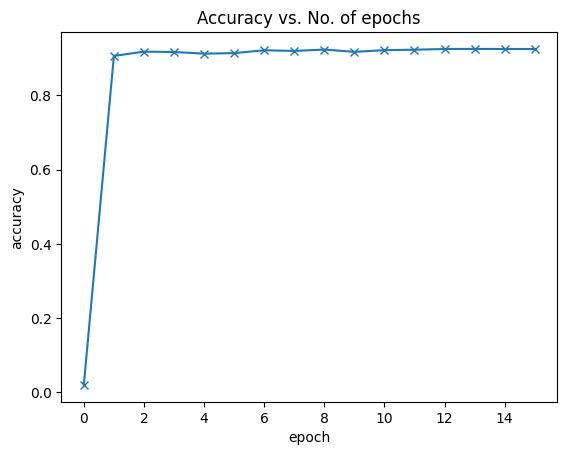

In [45]:
accuracies=[0.02,0.9063,0.9179,0.9169,0.9125,0.9139,0.9216,0.9198,0.9235,0.9173,0.9219,0.9231,0.9250,0.9252,0.9250,0.9250]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');